<a href="https://colab.research.google.com/github/AnRanbel/StudyPython/blob/master/BreasCancerPrediction_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip list

In [ ]:
pwd

'/content'

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



                 Predictor           VIF
0              radius_mean  32981.932892
1           perimeter_mean  30694.592305
2             radius_worst   7964.577524
3          perimeter_worst   3898.538972
4                area_mean   1397.107633
5               area_worst   1219.448662
6   fractal_dimension_mean    726.110837
7  fractal_dimension_worst    599.661757
Best parameters :  {'knn__base_estimator__metric': 'manhattan', 'knn__base_estimator__n_neighbors': 3, 'knn__base_estimator__weights': 'distance', 'knn__bootstrap': False, 'knn__bootstrap_features': True, 'knn__n_estimators': 5}
Accuracy : 97.37%
Classification report : 
               precision    recall  f1-score   support

           B       0.96      1.00      0.98        72
           M       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114

Confusion Matrix : 


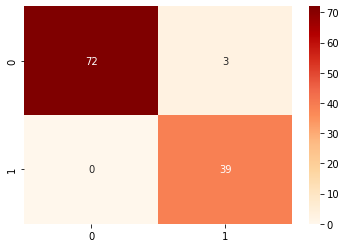

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.figure_factory as ff
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

from warnings import filterwarnings
filterwarnings("ignore")

# 在此导入time库，并在开头设置开始时间
# import time
# start = time.perf_counter()


# Data Preprocessing——Dealing with outliers
cancer = pd.read_csv('/content/Breast Cancer_data.csv')    # 类型DataFrame
cancer = cancer.drop('id', axis=1)      # 删除“id”列（DataFrame会默认有行索引和列索引)
def outlier(df):
    df_ = df.copy()
    df = df.drop('diagnosis', axis=1)

    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)

    iqr = q3 - q1

    lower_limit = q1 - (1.5 * iqr)
    upper_limit = q3 + (1.5 * iqr)

    for col in df.columns:
        for i in range(0, len(df[col])):
            if df[col][i] < lower_limit[col]:
                df[col][i] = lower_limit[col]

            if df[col][i] > upper_limit[col]:
                df[col][i] = upper_limit[col]

    for col in df.columns:
        df_[col] = df[col]

    return (df_)

cancer = outlier(cancer)


# Separating features and target
X = cancer.drop('diagnosis', axis=1)
y = cancer.diagnosis


# 方差膨胀因子(Variance Inflation Factor,VIF)：in our correlation matrix, many of our predictor variables were higly correlated.
# To avoid multicollinearity, we must deal with such columns.
def VIF(df):
    vif = pd.DataFrame()
    vif['Predictor'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values, col) for col in range(len(df.columns))]
    return vif

vif_df = VIF(X).sort_values('VIF', ascending = False, ignore_index = True)
print(vif_df.head(8))


# Removing features with VIF > 10,000
high_vif_features = list(vif_df.Predictor.iloc[:2])
vif_features = X.drop(high_vif_features, axis=1)

# Splitting data for training and testing
X_train, X_test, y_train, y_test = train_test_split(vif_features, y, test_size = 0.2, random_state = 39)

# KNN with VIF features and hyperparameter tuning

steps = [('scaler', StandardScaler()),
         ('knn', BaggingClassifier(KNeighborsClassifier()))]
pipeline = Pipeline(steps)

parameters = dict(knn__base_estimator__metric = ['euclidean', 'manhattan', 'minkowski'],
                  knn__base_estimator__weights =  ['uniform', 'distance'],
                  knn__base_estimator__n_neighbors = range(2,15),
                  knn__bootstrap = [True, False],
                  knn__bootstrap_features = [True, False],
                  knn__n_estimators = [5])

cv = GridSearchCV(pipeline,
                  param_grid = parameters,
                  cv = 5,
                  scoring = 'accuracy',
                  n_jobs = -1,
                  )

cv.fit(X_train, y_train)
y_pred = cv.predict(X_test)
knn_accuracy = accuracy_score(y_pred, y_test) * 100

print('\033[1m' +'Best parameters : '+ '\033[0m', cv.best_params_)
print('\033[1m' +'Accuracy : {:.2f}%'.format(knn_accuracy) + '\033[0m')
print('\033[1m' +'Classification report : '+ '\033[0m\n', classification_report(y_test, y_pred))

cm = confusion_matrix(y_pred, y_test)
print('\033[1m' +'Confusion Matrix : '+ '\033[0m')
sns.heatmap(cm, cmap = 'OrRd',annot = True, fmt='d')
plt.show()

# 在程序运行结束的位置添加结束时间
# end = time.perf_counter()
# print("运行耗时", end-start)